# ASSIGNMENT 2

## Chin Wai Yee - Data Preprocessing

In [1]:
import os
import kagglehub
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Download latest version
path = kagglehub.dataset_download("tristanzhang32/ai-generated-images-vs-real-images")

ai_dir = path + "/train/fake"
real_dir = path + "/train/real"

# Label 0 = AI-generated, Label 1 = Real
ai_data = [(os.path.join(ai_dir, f), 0) for f in os.listdir(ai_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
real_data = [(os.path.join(real_dir, f), 1) for f in os.listdir(real_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

full_data = ai_data + real_data
labels = [label for _, label in full_data]

In [2]:
# Train/val/test split
train_val_data, test_data = train_test_split(full_data, test_size=0.15, stratify=labels, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.15, stratify=[label for _, label in train_val_data], random_state=42)

# Custom Dataset
class ImagePathDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        try:
            image = Image.open(img_path)
    
            if image.mode == 'P':
                image = image.convert('RGBA')
                background = Image.new("RGB", image.size, (255, 255, 255))
                image = Image.alpha_composite(background.convert('RGBA'), image).convert('RGB')
            else:
                image = image.convert('RGB')
    
            if self.transform:
                image = self.transform(image)
            return image, label
    
        except (OSError, IOError) as e:
            print(f"Skipping corrupted image: {img_path} ({str(e)})")
            return self.__getitem__((idx + 1) % len(self.data))  # Try next image

In [3]:
# Data Augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Standard transform for val/test
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [4]:
# Create datasets and loaders
train_dataset = ImagePathDataset(train_data, transform=train_transform)
val_dataset = ImagePathDataset(val_data, transform=test_transform)
test_dataset = ImagePathDataset(test_data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## Loh Kin Ming - Model, Hyperparameters & Training

## Brandon Ting En Junn - Evaluation & Demo

In [5]:
import torch
import numpy as np
import seaborn as sns
from PIL import Image
from torchvision.models import efficientnet_b0
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, roc_curve, cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

In [7]:
# Load model
# model = efficientnet_b0()
# model.load_state_dict(torch.load('/kaggle/input/efficientnetb0/pytorch/default/1/model1_full.pth'))
model = torch.load("/kaggle/input/efficientnetb0/pytorch/default/1/model1_full.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
model.to(device)

y_true = []
y_pred = []
y_score = []

# Run inference on test_loader
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Run inference
        outputs = model(inputs)
        
        # Softmax function
        probits = torch.softmax(outputs, dim=1)
        
        # Prediction
        _, pred = torch.max(probits, dim=1)
        
        y_true.extend(labels.to("cpu").numpy())
        y_pred.extend(pred.to("cpu").numpy())
        y_score.extend(probits[:, 1].to("cpu").numpy())

/tmp/ipykernel_31/1416655042.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/kaggle/input/efficientnetb0/pytorch/default/1/model1_full.pth")


Skipping corrupted image: /kaggle/input/ai-generated-images-vs-real-images/train/real/13021.jpg (image file is truncated (0 bytes not processed))
Skipping corrupted image: /kaggle/input/ai-generated-images-vs-real-images/train/fake/8022.jpg (broken data stream when reading image file)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [8]:
print("y_true:", y_true)
print("y_pred:", y_pred)
print("y_score:", y_score)

y_true: [0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1

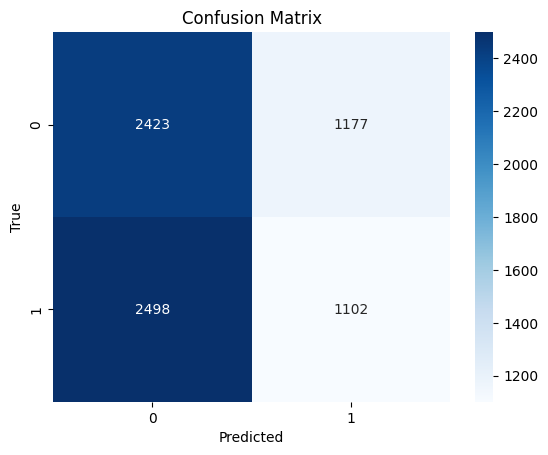

In [9]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [10]:
# Accuracy,Precision, Recall/Sensitivity, F1-Score, Kappa Coefficient
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall_sensitivity = recall_score(y_true, y_pred, average='weighted')
f1_score = f1_score(y_true, y_pred, average='weighted')
kappa_coefficient = cohen_kappa_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall/Sensitivity:", recall_sensitivity)
print("F1-Score:", f1_score)
print("Kappa Coefficient:", kappa_coefficient)

Accuracy: 0.4895833333333333
Precision: 0.4879625061491531
Recall/Sensitivity: 0.4895833333333333
F1-Score: 0.47180314091084496
Kappa Coefficient: -0.02083333333333326


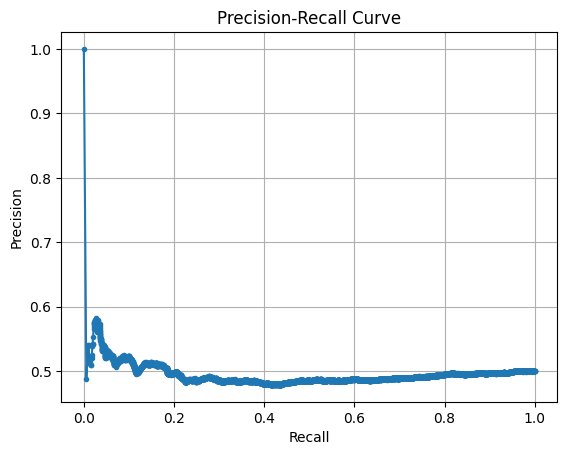

In [11]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_score)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

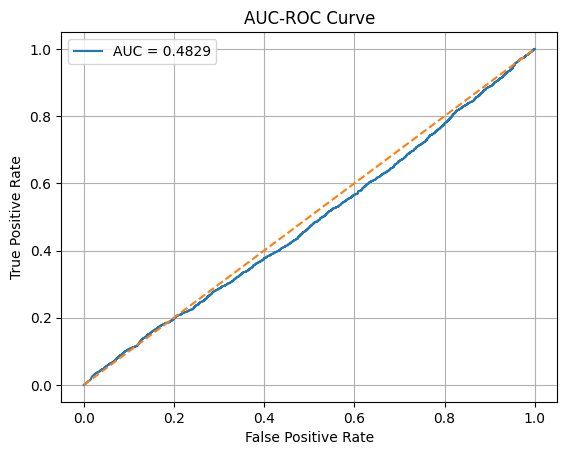

In [12]:
# AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_score)
auc_score = roc_auc_score(y_true, y_score)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()
plt.grid(True)
plt.show()